# Performance comparison

In [33]:
%matplotlib inline

from geosnap import datasets
import geopandas
import pandas
import esda
import libpysal as ps
from time import time
from os import cpu_count

PERMS = 9999

from libpysal.examples import get_path, load_example

## Data

In [2]:
%%time
from geosnap.io import store_census
store_census()

Copying: 100%|██████████| 258M/258M [01:58<00:00, 2.17MB/s]   
Copying: 100%|██████████| 86.1M/86.1M [00:42<00:00, 2.03MB/s]

CPU times: user 34.5 s, sys: 16.6 s, total: 51.1 s
Wall time: 2min 51s


- Counties

In [12]:
_ = load_example("NCOVR")

counties = geopandas.read_file(get_path("NAT.shp"))
w_counties = ps.weights.Queen.from_dataframe(counties)

- Tracts

In [9]:
%%time
tracts = datasets.tracts_2010()\
                 [["geoid", "median_household_income", "geometry"]]\
                 .dropna()

CPU times: user 20.4 s, sys: 6.7 s, total: 27.1 s
Wall time: 1min 35s


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
w_tracts = ps.weights.Queen.from_dataframe(tracts)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 16 islands with ids: 20, 50, 52, 24654, 35292, 36380, 41050, 41070, 43397, 45974, 48067, 48586, 48788, 63773, 68790, 70510.
  warnings.warn(message)


- Blocks

## Setup

In [26]:
def workbench(db, y_name, w, perms=PERMS, runs=5):
    print(f"Workbench working on a {cpu_count()}-core machine")
    times = {
        "No Numba": [],
        "Numba - Single Thread": [],
        "Numba - Multi Thread": [],
    }
    # Ensure function is compiled
    one = esda.Moran_Local(db[y_name], 
                           w, 
                           permutations=1,
                           numba=True,
                           n_jobs=1
                          )
    one = esda.Moran_Local(db[y_name], 
                           w, 
                           permutations=1,
                           numba=True,
                           n_jobs=-1
                          )
    for i in range(runs):
        # Pre-numba
        t0 = time()
        old = esda.Moran_Local(db[y_name], 
                               w, 
                               permutations=perms
                              )
        t1 = time()
        times["No Numba"].append(t1-t0)
        # Numba single thread

        t0 = time()
        one = esda.Moran_Local(db[y_name], 
                               w, 
                               permutations=perms,
                               numba=True,
                               n_jobs=1
                              )
        t1 = time()
        times["Numba - Single Thread"].append(t1-t0)
        # Numba multi thread
        t0 = time()
        one = esda.Moran_Local(db[y_name], 
                               w, 
                               permutations=perms,
                               numba=True,
                               n_jobs=-1
                              )
        t1 = time()
        times["Numba - Multi Thread"].append(t1-t0)
    return pandas.DataFrame(times)

## All counties

In [28]:
%%time
res_counties = workbench(counties, 
                         "HR70", 
                         w_counties, 
                         perms=PERMS, 
                         runs=7
                        )

CPU times: user 1min 51s, sys: 1.66 s, total: 1min 52s
Wall time: 1min 58s


In [31]:
res_counties.mean()

No Numba                 9.557701
Numba - Single Thread    3.209537
Numba - Multi Thread     2.574807
dtype: float64

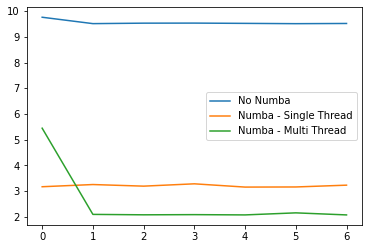

In [32]:
res_counties.plot()

## All tracts

## All blocks